In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.signal
import pandas as pd
import IPython.display as ipd
import librosa
import matplotlib.colors as mcolors

In [2]:
data_dir = '../data/'

In [3]:
data_file_list = glob(data_dir + '*.wav')

In [4]:
data_file_list[0]

'../data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav'

In [5]:
ipd.Audio(data_file_list[0])

In [6]:
SAMPLE_RATE = 20000

In [7]:
raw_neural_data, sr = librosa.load(data_file_list[0], sr = SAMPLE_RATE)

In [8]:
stop_time = len(raw_neural_data) / SAMPLE_RATE
time = np.arange(0, stop_time, step=(1/SAMPLE_RATE))

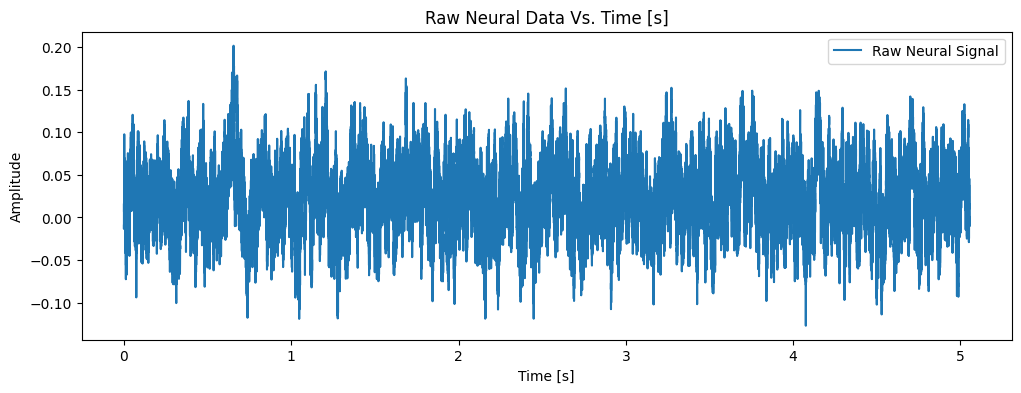

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(time, raw_neural_data)
plt.title('Raw Neural Data Vs. Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(['Raw Neural Signal'])
plt.show()

In [10]:
# It appears there is a trend in the data that is non-zero
detrend_y = scipy.signal.detrend(raw_neural_data)

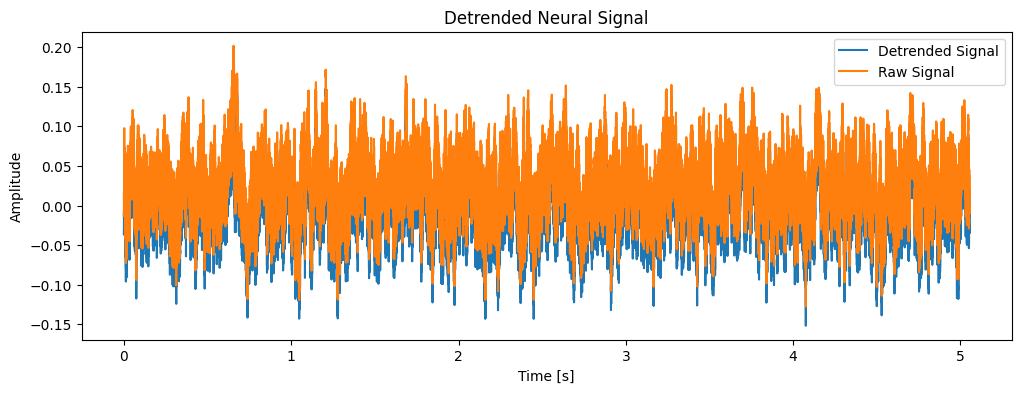

In [11]:
# Plotting the Detrended Signal
plt.figure(figsize=(12, 4))
plt.plot(time, detrend_y, label='Detrended Signal')
plt.plot(time, raw_neural_data, label='Raw Signal')
plt.title('Detrended Neural Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


## Frequency Analysis of Raw Neural Data

In [12]:
FFT = np.fft.fft(detrend_y)
half_length_of_the_FFT = int(len(FFT)/2)

# Creating frequency bins
N = len(FFT)

freq_bins = np.arange(start=0, stop=(sr/2), step=(sr/N))

In [13]:
len(freq_bins) == int(len(FFT)/2)

True

In [14]:
psd = FFT * np.conj(FFT)/ len(FFT)

In [15]:
psd = psd[0:len(psd)//2]

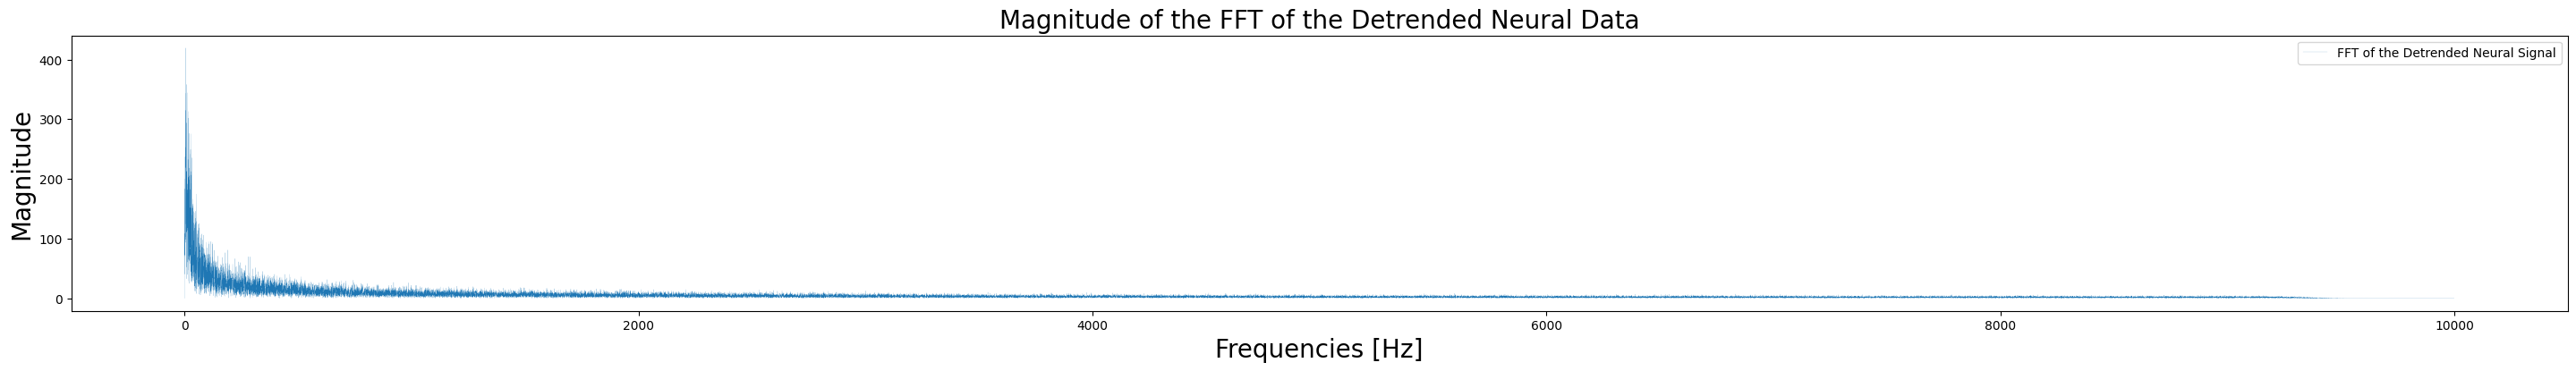

In [16]:
# Plot the Frequency Domain Transform of the Detrended Neural Data
plt.figure(figsize=(36,4))
plt.plot(freq_bins, abs(FFT[0:len(FFT)//2]), 
         label='FFT of the Detrended Neural Signal', linewidth=.1)
plt.title('Magnitude of the FFT of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Magnitude', fontsize=20)
plt.legend()
plt.show()

/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Volumes/T7/Github/Neuralink-Compression-Challenge/py_encoding_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


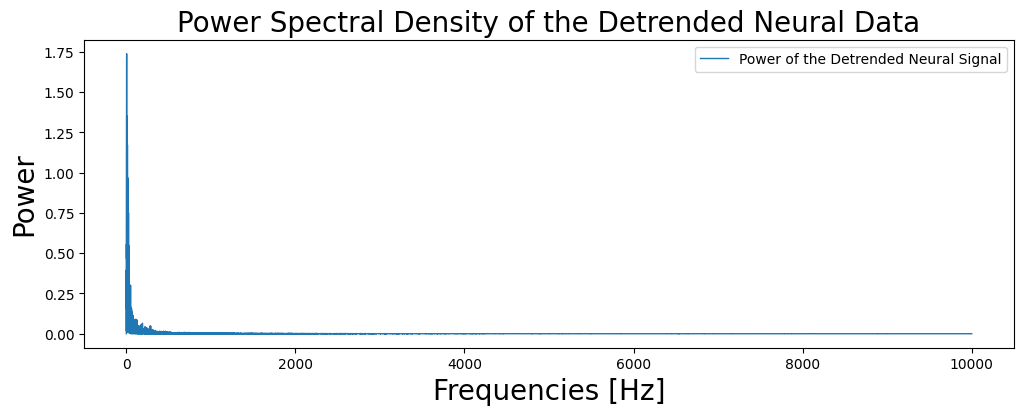

In [17]:
# Plot of the PSD of the Detrended Neural Data
plt.figure(figsize=(12,4))
plt.plot(freq_bins, psd, 
         label='Power of the Detrended Neural Signal', linewidth=1)
plt.title('Power Spectral Density of the Detrended Neural Data', fontsize=20)
plt.xlabel('Frequencies [Hz]', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.legend()
plt.show()


In [18]:
len(FFT) - 1

101069

In [19]:
freq_bins[0]

0.0

In [20]:
FFT[0]

(-0.01885454356670735+5.88418203051333e-15j)

In [21]:
FFT[0]

(-0.01885454356670735+5.88418203051333e-15j)

In [22]:
# Sorting the peaks and printing the corresponding indices:
freq_amplitudes = abs(FFT[0:int(len(FFT)/2)])
freq_amplitudes_df = pd.DataFrame(freq_amplitudes, columns = ['Amplitude'])
freq_amplitudes_df_sorted = freq_amplitudes_df.sort_values(by='Amplitude', ascending=False).head(20)

In [23]:
freq_amplitudes_df_sorted.head()

,Amplitude
21,419.206039
22,369.885809
35,358.179650
68,344.337993
27,343.535508


In [24]:
len(freq_amplitudes)

50535

In [25]:
def fft_filter_custom(percentage, freq_amplitudes, freq_bins, FFT):
    threshold = percentage * (2 * freq_amplitudes / len(freq_bins)).max()
    filtered_FFT = FFT.copy()
    filtered_FFT = np.abs(filtered_FFT)
    filtered_FFT = 2*filtered_FFT / len(freq_bins)
    filtered_FFT[filtered_FFT <= threshold]=0
    return filtered_FFT
    

In [26]:
# Plotting the thresholded FFT
# This is incorrect: the signal is mirrored about the vertical axis of the graph
percentage = 0.5

fft_filter_custom = fft_filter_custom(percentage, freq_amplitudes, freq_bins, FFT)
time_filtered_customer = np.fft.ifft(fft_filter_custom)


In [ ]:

plt.figure(figsize=(12, 4))
plt.plot(time, 
         np.fft.ifft(fft_filter_custom(percentage, freq_amplitudes, freq_bins, FFT)), 
         color=list(mcolors.TABLEAU_COLORS.keys())[0],
         label='Thresholded Detrended Signal')
plt.title('Filtered Signal Thresholded at %0.0f%% of the Maximum Frequency'% (percentage*100))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## [Detecting noise by examining the correllation between the residual and the original waveform.](https://towardsdatascience.com/noise-cancellation-with-python-and-fourier-transform-97303314aa71)